In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("../data/train_ZoGVYWq.csv")
test = pd.read_csv("../data/test_66516Ee.csv")
submission = pd.read_csv("../data/sample_submission_sLex1ul.csv")

# Setup Data

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [4]:
#SETUP DATA
data = pd.concat([train, test], axis=0).reset_index(drop = True)
data["sourcing_channel"] = LabelEncoder().fit_transform(data["sourcing_channel"])
data["residence_area_type"] = LabelEncoder().fit_transform(data["residence_area_type"])

In [5]:
train = data[:train.shape[0]].reset_index(drop =True)
test = data[train.shape[0]:].reset_index(drop =True)

train_id = train[["id"]]
test_id = test[["id"]]
target = train.renewal

train = train.drop(["id","renewal"], axis=1)
test = test.drop(["id","renewal"], axis=1)

# Running  Model

In [6]:
import lightgbm as lgb
def model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train,categorical_feature = ["sourcing_channel","residence_area_type"])
    dval = lgb.Dataset(x_test, label=y_test, categorical_feature = ["sourcing_channel","residence_area_type"])
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 200,
        "metric":"auc",
        "objective": "binary",
        "learning_rate":0.15,
        "num_leaves":5,
        "max_depth":5,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 7676,
        "seed":97898
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))
    
    global meta_train_tid
    meta_train_tid[train_index] = model.predict(x_train, num_iteration=model.best_iteration or 5000)

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [7]:
meta_train = np.zeros(train.shape[0])
meta_train_tid = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=786)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", roc_auc_score(target, meta_train)

test_id["renewal"] = pd.DataFrame(np.array(meta_test).T).rank(pct = True, axis=0).mean(axis=1)
train_id["renewal"] = meta_train
train_id["renewal_tid"] = meta_train_tid

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.852123	valid_1's auc: 0.844893
[200]	training's auc: 0.860104	valid_1's auc: 0.845137
[300]	training's auc: 0.866087	valid_1's auc: 0.844467
Early stopping, best iteration is:
[144]	training's auc: 0.855784	valid_1's auc: 0.84545
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.85425	valid_1's auc: 0.836514
[200]	training's auc: 0.861637	valid_1's auc: 0.837494
[300]	training's auc: 0.868623	valid_1's auc: 0.838022
[400]	training's auc: 0.873786	valid_1's auc: 0.836659
[500]	training's auc: 0.879172	valid_1's auc: 0.836436
Early stopping, best iteration is:
[315]	training's auc: 0.869465	valid_1's auc: 0.838171
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.851927	valid_1's auc: 0.842404
[200]	training's auc: 0.860249	valid_1's auc: 0.841456
Early stopping, best iteration is:
[78]	training's auc: 0.849942	valid_1's auc: 0.8

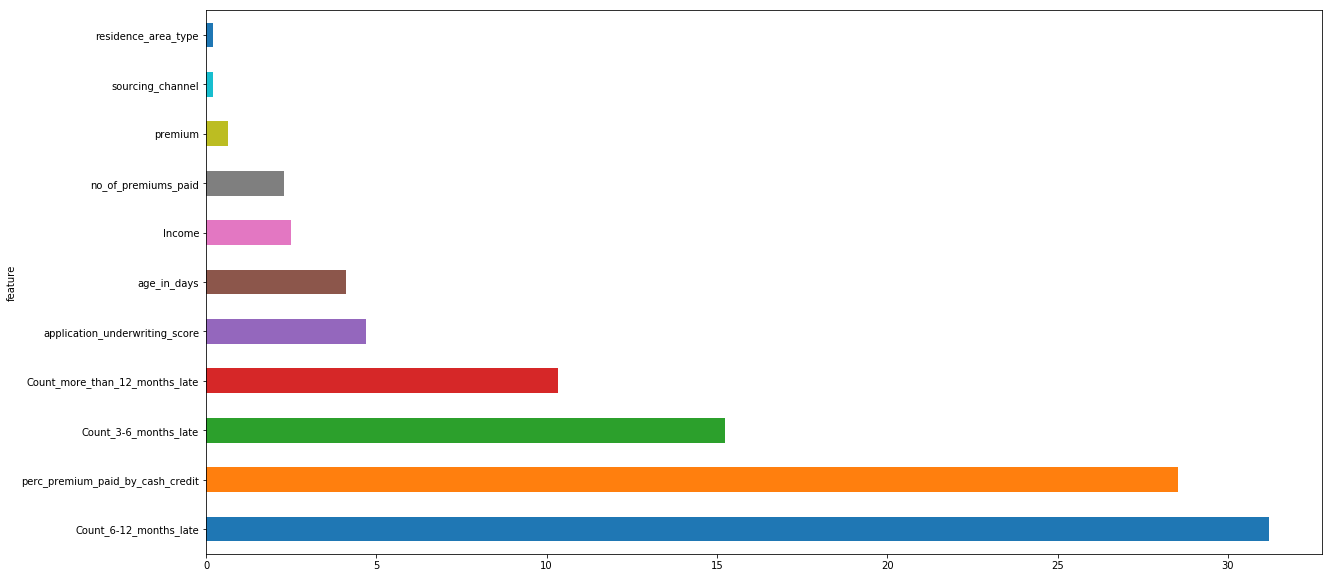

In [8]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


# Working on Incentives

In [9]:
def get_effort(incentive):
    return 10*(1-np.exp(-incentive/400.0))
    
def get_improvement_in_renewal_probability(incentive):
    effort = get_effort(incentive)
    return 20*(1-np.exp(-effort/5.0))

def gradient_improvement_in_renewal_probability(incentive):
    dpde = 4 * np.exp(-get_effort(incentive)/5.0)
    dedi = np.exp(-incentive/400.0)/40.0
    dpdi = dpde * dedi
    return  dpdi
    
def revenue_score(incentive, benchmark, premium):
    cdp = get_improvement_in_renewal_probability(incentive)
    profits = ((benchmark + (cdp*benchmark/100.0)) * premium)-incentive
    return np.sum(profits)

def score_gradient(incentive, benchmark, premium):
    z=  np.exp(-incentive/400.0)-(incentive/400.0)-2
    return ((benchmark * premium * np.exp(z)/400.0)-1)

def second_score_gradient(incentive, benchmark, premium):
    a = np.exp(-incentive/400.0)-(incentive/400.0)
    b = (benchmark* premium* np.exp(a))/400.0
    return (-(b)-(1.0/400.0))/400.0

def learn(benchmark, premium, early_stopping = 5, start_incentive = 1700, min_improvement = 0.005, verbose = True):
    incentive = start_incentive
    best_incentive = start_incentive
    
    score = 0
    best_score = 0
    
    counter = 0
    best_counter = 0
    no_improvement_counter = 0
    
    while True:
        lr = (incentive - 0)
        gradient = score_gradient(incentive, benchmark, premium)
        try:
            incentive += lr*(gradient*0.5 + 0.5*prev_gradient)
        except:
            incentive += lr*gradient
            
        
        score = revenue_score(incentive, benchmark, premium)
        counter +=1
        prev_gradient = gradient

        if (score-best_score> min_improvement):
            best_score = score
            best_incentive = incentive
            best_counter = counter
            
            no_improvement_counter = 0
            if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
        else:
            if (no_improvement_counter > early_stopping):
                if verbose: print "Early Stopping, Best Iteration Round: {}".format(best_counter)
                return best_incentive, best_score
            else:
                no_improvement_counter +=1
                if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
    

In [11]:
def annealing(benchmark, premium, num_annealing = 30):
    results = []
    for incentive in range(0,premium,int(float(premium)/num_annealing)):
        results.append(learn(benchmark, premium, early_stopping = 5, start_incentive = incentive, min_improvement = 0.005, verbose = False))
    return sorted(results, key = lambda x: x[1])[-1][0]    

In [12]:
train_incentives = []

for i, (benchmark, premium) in enumerate(zip(train_id["renewal"], train["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    train_incentives.append(annealing(benchmark, premium))
    
train_incentives = pd.Series(train_incentives)
train_incentives[train_incentives<0] = 0

generated_score = revenue_score(train_incentives, train_id["renewal"], train["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(train_incentives)), train_id["renewal"], train["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Completed 40000 Rows
Completed 50000 Rows
Completed 60000 Rows
Completed 70000 Rows
Score using generated Incentive: 916650795.976
Score using 1650 as Incentive: 834157533.56
Score Improvement: 1.09889410465


In [13]:
test_incentives = []

for i, (benchmark, premium) in enumerate(zip(test_id["renewal"], test["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    test_incentives.append(annealing(benchmark, premium))
    
test_incentives = pd.Series(test_incentives)
test_incentives[test_incentives<0] = 0

generated_score = revenue_score(test_incentives, test_id["renewal"], test["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(test_incentives)), test_id["renewal"], test["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Score using generated Incentive: 215006589.053
Score using 1650 as Incentive: 173217617.716
Score Improvement: 1.24125127621


# Training for Incentives

In [14]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 200,
        "metric":"rmse",
        "objective": "regression",
        "learning_rate":0.05,
        "num_leaves":10,
        "max_depth":10,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 7676,
        "seed":97898
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [15]:
train["prediction"] = train_id["renewal"]
test["prediction"] = train_id["renewal"]

meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=786)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = train_incentives[train_index], train_incentives[test_index]

    model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", mean_squared_error(train_incentives, meta_train)
test_id["incentives"] = np.array(meta_test).T.mean(axis=1)
train_id["incentives"] = meta_train

test_id["incentives"] += test_incentives
test_id["incentives"] /= 2

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 10.9867	valid_1's rmse: 11.3205
[200]	training's rmse: 7.59822	valid_1's rmse: 8.05659
[300]	training's rmse: 6.99095	valid_1's rmse: 7.59877
[400]	training's rmse: 6.66111	valid_1's rmse: 7.35134
[500]	training's rmse: 6.36321	valid_1's rmse: 7.17682
[600]	training's rmse: 6.21088	valid_1's rmse: 7.13109
[700]	training's rmse: 6.06763	valid_1's rmse: 7.12562
[800]	training's rmse: 5.95392	valid_1's rmse: 7.08149
[900]	training's rmse: 5.80983	valid_1's rmse: 7.04798
[1000]	training's rmse: 5.68979	valid_1's rmse: 7.02299
[1100]	training's rmse: 5.57732	valid_1's rmse: 7.01381
[1200]	training's rmse: 5.49758	valid_1's rmse: 6.99933
[1300]	training's rmse: 5.36648	valid_1's rmse: 6.98012
[1400]	training's rmse: 5.28329	valid_1's rmse: 6.96101
[1500]	training's rmse: 5.17559	valid_1's rmse: 6.95663
[1600]	training's rmse: 5.10645	valid_1's rmse: 6.9339
[1700]	training's rmse: 5.02786	valid_1's rmse: 6.9

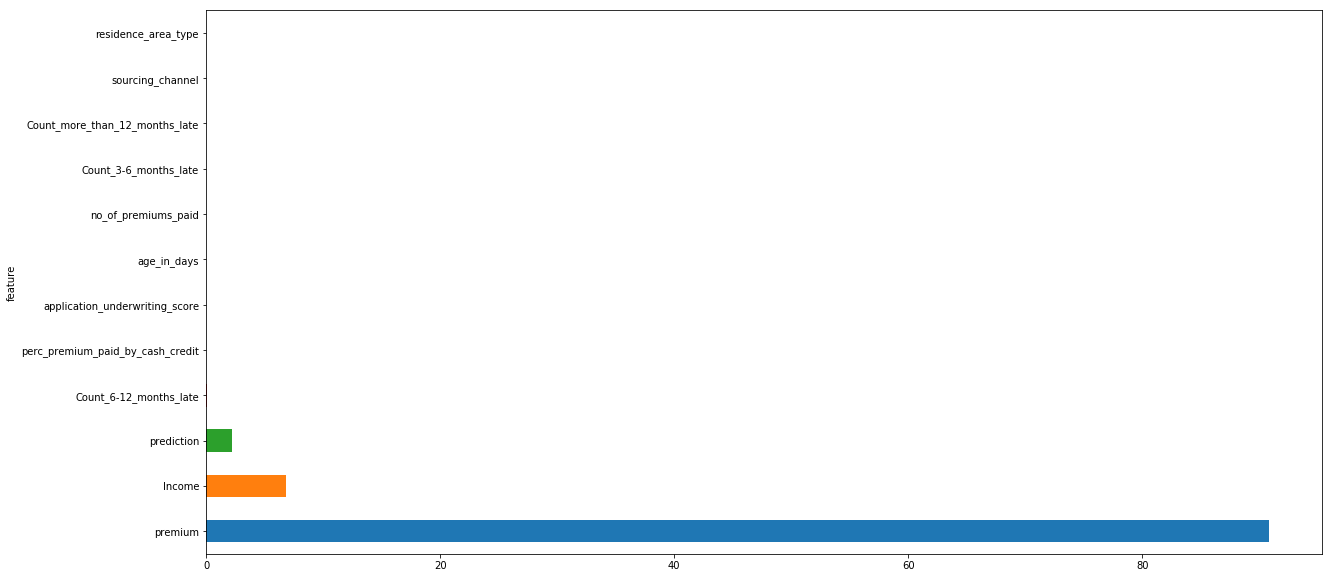

In [16]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


In [21]:
submission = submission[["id"]].merge(test_id[["id","renewal","incentives"]], how = "left", on = "id")
submission = submission[["id", "renewal", "incentives"]]
submission.loc[submission.incentives < 0,"incentives"] = 0
submission.to_csv("csv/eda1.csv", index=False)

In [20]:
submission

,id,renewal,incentives
0,649,0.927022,173.436762
1,81136,0.681624,401.166446
2,70762,0.152460,141.844594
3,53935,0.495015,210.188465
4,15476,0.440755,311.237112
5,64797,0.702738,391.858368
6,67412,0.096687,85.419714
7,44241,0.075900,35.435703
8,5069,0.901923,465.280117
9,16615,0.922099,648.830457
